# MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

<Figure size 640x480 with 1 Axes>

In [6]:
y[0]

'5'

In [7]:
import numpy as np

In [8]:
y = y.astype(np.uint8)

In [9]:
# Figure 3-1 shows sample of data set here.

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] # Set aside our test set.

# Training a Binary Classifier

In [11]:
y_train_5 = (y_train == 5) # True for all 5s.  False for all other digits.
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) # Don't forget to seed the random number generator.
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

In [14]:
from joblib import dump, load

dump(sgd_clf, "first_clf.pkl")

['first_clf.pkl']

## Measuring Accuracy Using Cross-Validation

It's fairly easy to create your own cross validation method.  Book gives one example.  That example isn't provided here because we just use the built-in sklearn cross_val_score method.

In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Above 95% _accuracy_ on all all cross validation folds on the first try?  Probably too good to be true.  Let's explore things further.

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

90% accuracy always guessing the number is not a 5.  That's because only about 10% of the numbers are 5s, unsurprisingly.

This demonstrates why accuracy is not the preferred metric for classifiers, especially for _skewed data sets_ where one class appears more frequently than the others.

## Confusion Matrix

Look at the number of times a classifier confused one class with another.

In [18]:
from sklearn.model_selection import cross_val_predict

sgd_clf = load("first_clf.pkl")

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

The confusion matrix columns are predicted classes and the rows are the actual classes.  There is some code on [Kaggle](https://www.kaggle.com/grfiv4/plot-a-confusion-matrix) that shows a method for plotting the confusion matrix in a more readable format.

The results shown in the table below are not so good.  The classifier only classified 2/3 of the actual 5s correctly.

||Non-Five Predicted|Five Predicted|
|----------|----------|----------|
|Non-Five Class|53892|687|
|Five Class|1891|3530|

The accuracy of positive predictions is its _precision_.

_Precision_ = $\frac{True Positives}{True Positives + False Positives}$

Precision is how often our classifier is correct when it claims an image represents a 5.

So, in the example above the math is as follows: 3530 / (3530 + 687) = 0.837.

Precision can be made 100% by making a single positive predicition and ensureing it is correct.

So, in addition to precision, _recall (a.k.a sensitivity, a.k.a true positive rate - TPR)_ is used.

_Recall_ = $\frac{True Positives}{True Positives + False Negatives}$

Recall is how many of the 5s our classifier detects.

So, in the example above the math is as follows: 3530 / (3530 + 1891) = 0.651.

Figuring out "True Negative", "True Positive", "False Negative", "False Positive" for our confusion matrix looks like so:

||Negative|Positive|
|----------|----------|----------|
|Negative|True Negative|False Positive|
|Positive|False Negative|True Positive|

## Precision and Recall

In [20]:
from sklearn.metrics import precision_score, recall_score

# When our classifier claims on image is a five it is correct 83.1 % of the time.
precision_score(y_train_5, y_train_pred) # 3530 / (3530 + 687) = 0.831

0.8370879772350012

In [21]:
# Our classifier only detects 65.1 % of the 5s.
recall_score(y_train_5, y_train_pred) # 3530 / (3530 + 1891) = 0.651

0.6511713705958311

_$f_{1}$ score_ combines precision and recall into a single metric.

$f_{1}$ score is the harmonic mean of precision and recall.  Unlike regular mean, harmonic mean gives more weight to low values.  So, to get a high $f_{1}$ score both precision and recall must have high values.

$f_{1}$ = $\frac{True Positive}{True Postive + \frac{False Negative + False Positive}{2}}$

This score favors classifiers whose precision and recall have similar values.

Sometimes you want a high value for precision, but don't necessarily care about recall and vice versa.

In [22]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

## Precision / Recall Tradeoff

Increasing precision reduces recall and increasing recall reduces precision.

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores # Book y_scores array([161855.74]).  Why the huge difference?  Is some_digit different?

array([2164.22030239])

In [24]:
threshold = 0 # SGDClassifier uses a threshold of 0.

In [25]:
# With a threshold of 0 this returns the same result as SGDClassifier.predict().

y_some_digit_pred = (y_scores > threshold) 
y_some_digit_pred # Current recall = 1/(1 + 0) = 1

array([ True])

In [26]:
# Confirm raising the threshold decreases recall.

threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # Current recall = 0/(0 + 1) = 0

array([False])

Increasing the threshold decreases recall.

How do we know what threshold to use?

Get all the decision scores, then plot the recall/precision curve.

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [44]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [45]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [46]:
help(precision_recall_curve)

Help on function precision_recall_curve in module sklearn.metrics.ranking:

precision_recall_curve(y_true, probas_pred, pos_label=None, sample_weight=None)
    Compute precision-recall pairs for different probability thresholds
    
    Note: this implementation is restricted to the binary classification task.
    
    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.
    
    The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
    true positives and ``fn`` the number of false negatives. The recall is
    intuitively the ability of the classifier to find all the positive samples.
    
    The last precision and recall values are 1. and 0. respectively and do not
    have a corresponding threshold.  This ensures that the graph starts on the
    y axis.
    
    Re

In [47]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])

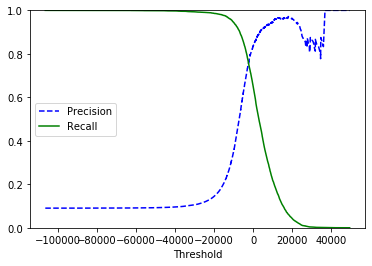

In [48]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [49]:
# help(plt.plot)

In [50]:
def plot_precision_vs_recall(x, y, xlabel="", ylabel=""):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

__Precison vs Recall curve__

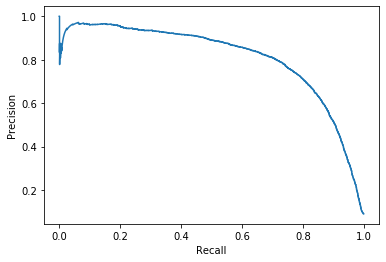

In [52]:
plot_precision_vs_recall(recalls[:-1], precisions[:-1], "Recall", "Precision")
plt.show()

In [53]:
# Choose a value that will give 90% precision.
# Instead of calling the classifier's predict method, find the indices of the scores that will give 90% precision.

# 4000 comes from looking at the precision and recall on the threshold plot above and choosing the number that gets
# precision as close to 90% as possible while keeping recall high.
# Precision drops off sharply around 25000 threshold.
# Plot may be different when it's run again.
y_train_pred_90 = (y_scores > 4000) 

In [54]:
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [55]:
precision_score(y_train_5, y_train_pred_90) # Higher precsion than the book by 4%.

0.9085523880044428

In [56]:
recall_score(y_train_5, y_train_pred_90) # Lower recall than the book by 24%.

0.4526840066408412

In [57]:
# help(precision_score)

__"If someone says 'let's reach 99% precision," you should adk, 'at what recall?'"__

## The ROC Curve

_The receiver operating characteristic (ROC)_ curve.
* Used with binary classifiers
* Similar to precision/recall curve
* Plots recall, a.k.a true positive rate (TPR), against false positive rate (FPR)

In [58]:
# Calculate TPR and FPR from various threshold values.

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [59]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

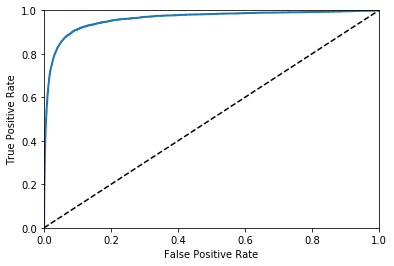

In [43]:
plot_roc_curve(fpr, tpr)
plt.show()

Tradeoff: The higher the recall (TPR), the more false positives.

Reading the TPR vs FPR chart:
* Dashed line represents the ROC curve of a random classifier
* A good classifier stays away from that line and toward the top left corner

Start with AUC, pg. 94.